In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

In [ ]:
MAX_DEPTH_VALUE = 2 ** 16  # 2的16次幂

def read_coco_annotations(json_file):
    with open(json_file, 'r') as f:
        annotations = json.load(f)
    return annotations

def calculate_center(bbox):
    x, y, w, h = bbox
    center_x = x + w / 2
    center_y = y + h / 2
    return int(center_x), int(center_y)

def get_depth_from_image(depth_image, center_point):
    x, y = center_point
    return depth_image[y, x]

def plot_histogram(depth_values, bins, title, x_title, y_title):
    plt.hist(depth_values, bins=bins, edgecolor='black')
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(title)
    plt.show()

def main(annotation_file, depth_image_dir, sample_size=100):
    annotations = read_coco_annotations(annotation_file)
    
    # 获取 image_info 列表
    image_info_list = annotations['images']
    
    # 随机抽样 image_info 条目
    sampled_images = random.sample(image_info_list, min(sample_size, len(image_info_list)))
    
    depth_values = []
    
    # 处理每个抽样的图像
    for image_info in sampled_images:
        image_id = image_info['id']
        image_filename = os.path.basename(image_info['file_name'])
        depth_image_path = os.path.join(depth_image_dir, image_filename.replace('.jpg', '.png'))
        
        # 检查深度图像路径是否存在
        if not os.path.exists(depth_image_path):
            continue
        
        # 打开深度图像
        depth_image = np.array(Image.open(depth_image_path), dtype=np.float32)
        
        for ann in annotations['annotations']:
            if ann['image_id'] == image_id:
                bbox = ann['bbox']
                center = calculate_center(bbox)
                depth_value = get_depth_from_image(depth_image, center)
                
                # 进行归一化
                normalized_depth_value = depth_value / MAX_DEPTH_VALUE
                
                # 确保深度值有效
                if np.isnan(normalized_depth_value) or normalized_depth_value < 0 or normalized_depth_value > 1:
                    continue
                
                depth_values.append(normalized_depth_value)

    # 确保有有效的深度值用于绘制直方图
    if depth_values:
        # 绘制直方图
        plot_histogram(depth_values, bins=np.linspace(0, 1, 21), title='Depth Histogram',
                       x_title='Relative Depth', y_title='Number of Objects')
    else:
        print("No valid depth values to plot.")


In [ ]:
# 定义常量
MAX_DEPTH_VALUE = 2 ** 16  # 2的16次幂

def read_coco_annotations(json_file):
    with open(json_file, 'r') as f:
        annotations = json.load(f)
    return annotations

def calculate_center(bbox):
    x, y, w, h = bbox
    center_x = x + w / 2
    center_y = y + h / 2
    return int(center_x), int(center_y)

def get_depth_from_image(depth_image, center_point):
    x, y = center_point
    return depth_image[y, x]

def plot_histograms(depth_values_dict, bins, category_colors, title, x_title, y_title):
    num_categories = len(depth_values_dict)
    fig, axes = plt.subplots(num_categories, 1, figsize=(10, 6*num_categories))  # 根据类别数量生成多个子图
    
    if num_categories == 1:
        axes = [axes]  # 当只有一个类别时，将axes转为列表
    
    for ax, (category, depth_values) in zip(axes, depth_values_dict.items()):
        color = [c/255.0 for c in category_colors[category]]  # 转换颜色值为0-1之间
        ax.hist(depth_values, bins=bins, alpha=0.7, label=category, color=color, edgecolor='black')
        ax.set_xlabel(x_title, fontsize=14)
        ax.set_ylabel(y_title, fontsize=14)
        ax.set_title(f'{title} ({category})', fontsize=16)
        ax.legend(title='Category', fontsize=12)
        ax.grid(True)
    
    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def main(annotation_file, depth_image_dir, category_colors, sample_size=100):
    annotations = read_coco_annotations(annotation_file)
    
    # 获取 image_info 列表
    image_info_list = annotations['images']
    
    # 随机抽样 image_info 条目
    sampled_images = random.sample(image_info_list, min(sample_size, len(image_info_list)))
    
    depth_values_dict = {category: [] for category in category_colors.keys()}
    
    # 处理每个抽样的图像
    for image_info in sampled_images:
        image_id = image_info['id']
        image_filename = os.path.basename(image_info['file_name'])
        depth_image_path = os.path.join(depth_image_dir, image_filename.replace('.jpg', '.png'))
        
        # 检查深度图像路径是否存在
        if not os.path.exists(depth_image_path):
            continue
        
        # 打开深度图像
        depth_image = np.array(Image.open(depth_image_path), dtype=np.float32)
        
        for ann in annotations['annotations']:
            if ann['image_id'] == image_id:
                bbox = ann['bbox']
                category_id = ann['category_id']
                category_name = [cat['name'] for cat in annotations['categories'] if cat['id'] == category_id][0]
                
                if category_name not in category_colors:  # 跳过那些没有指定颜色的类别
                    continue

                center = calculate_center(bbox)
                depth_value = get_depth_from_image(depth_image, center)
                
                # 进行归一化
                normalized_depth_value = depth_value / MAX_DEPTH_VALUE
                
                # 确保深度值有效
                if np.isnan(normalized_depth_value) or normalized_depth_value < 0 or normalized_depth_value > 1:
                    continue
                
                depth_values_dict[category_name].append(normalized_depth_value)

    # 确保有有效的深度值用于绘制直方图
    if any(depth_values_dict.values()):
        # 绘制直方图
        plot_histograms(depth_values_dict, bins=np.linspace(0, 1, 21), category_colors=category_colors,
                        title='Depth Histogram', x_title='Relative Depth', y_title='Number of Objects')
    else:
        print("No valid depth values to plot.")

In [ ]:
if __name__ == "__main__":
    annotation_file = "/opt/data/private/fcf/mmdetection/data/HazyDet-365k/train/train_coco.json"
    depth_image_dir = "/opt/data/private/fcf/mmdetection/data/HazyDetdevkit/HazyDet/depth_images"
    main(annotation_file, depth_image_dir, sample_size=1000)

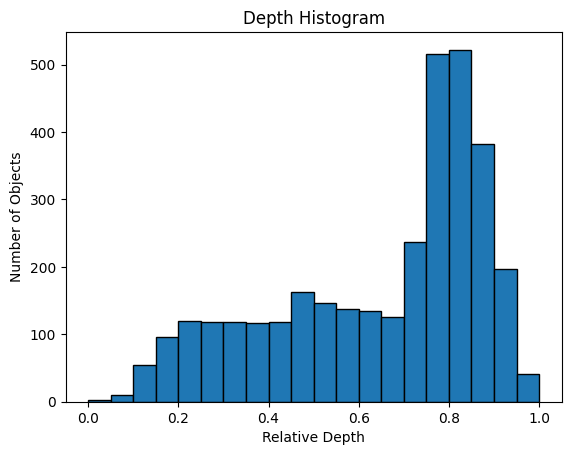

In [9]:
if __name__ == "__main__":
    annotation_file = "/opt/data/private/fcf/mmdetection/data/HazyDet-365k/train/train_coco.json"
    depth_image_dir = "/opt/data/private/fcf/mmdetection/data/HazyDetdevkit/HazyDet/depth_images"
    
    category_colors = {
        'car': (239,56, 83),          #
        'bus': (28, 153, 35),        #
        'truck': (38, 88, 147)   # 

        # ... 其他类别
    }
    
    main(annotation_file, 
         depth_image_dir,
        #  category_colors,
         sample_size=100
         )